# Méthodes de type Newton pour l'optimisation sans contraintes

Dans ce TP, on cherche à tester les différentes méthodes de type Newton :  
- Newton locale
- Newton globalisée
- quasi-Newton, ici BFGS

## Import de quelques bibliothèques bien utiles

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.linalg as la

## Préliminaires

### Pour les graphiques (contours, itérés)

In [130]:
def plot_contour(a, b, c, d, f):
    delta = 0.05
    x0, x1 = np.meshgrid(np.arange(a, b, delta), np.arange(c, d, delta))
    plt.contour(x0, x1, f((x0, x1)), 50)
    
def plot_iteres(iteres, couleur):
    plt.plot(iteres[:,0], iteres[:,1], color=couleur, marker="+", linestyle="-")

### Pour le critère d'arrêt des méthodes d'optimisation

In [29]:
def arrêt(X,g,eps,k,IterMax):
    return(np.linalg.norm(g(X))< eps or k >= IterMax)
   

### Pour comparaison à la méthode de gradient avec recherche linéaire de Wolfe

copier-coller les codes nécessaires du TP1.

In [165]:
def RL_WOLFE(X, d, f, g, s0 = 1.0, eps1 = 0.01, eps2 = 0.99):
    # X est l'itéré courant x_k
    # d est la direction de recherche
    # f est la fonction qui évalue le critère pour en un point X donné
    # g est la fonction qui évalue le gradient du critère pour en un point X donné
    # s_0 est la longueur de pas initiale
    # eps1 et eps2 sont les paramètres utilisés dans les conditions de Wolfe
  
    s = s0
    k = 0
    sg = 0.0
    sd = 1000.0
    
    while f(X+s*d)>f(X)+ eps1*s*np.dot(g(X),d) or np.dot(g(X+s*d),d) < eps2*np.dot(g(X),d):
        if f(X+s*d)>f(X)+ eps1*s*np.dot(g(X),d):
            sd=s
            s=(sg+sd)/2
        elif np.dot(g(X+s*d),d) < eps2*np.dot(g(X),d):
            sg=s
            s=(sg+sd)/2
        k=k+1 
                
    return s


def ppd_RL_Wolfe(f, g, X0, IterMax, eps):
    # f est la fonction qui évalue le critère pour en un point X donné
    # g est la fonction qui évalue le gradient du critère pour en un point X donné
    # X0 est le point de départ de l'algorithme
    # IterMax est le nombre d'itérations réalisées
    # eps est une tolérance fixée pour le critère d'arrêt
        
    X      = X0.copy()
    iteres = np.zeros(shape=(IterMax+1, len(X))) # pour stocker les itérés
    steps  = np.zeros(shape=(IterMax,)) # pour stocker les pas successifs
    iteres[0]=X
    k = 0

    while arrêt(X,g,eps,k,IterMax)== False:
        # Calcul de la direction de descente
        d_k = -g(X)
        # Pas de Wolfe
        pas = RL_WOLFE(X, d_k, f, g, s0 = 1.0, eps1 = 0.01, eps2 = 0.99)
        # Calcul de l'itéré suivant
        X=X + pas*d_k
        # Stockage du pas
        steps[k] = pas 

        # Stockage du nouvel itéré
        iteres[k+1] = X
        
        k = k+1
        # Mise à jour du critère d'arrêt
        

    return iteres[:k+1,:], k, steps[:k]

### Une nouvelle fonction test : la fonction de Rosenbrock

$$f_1(x) = 100(x_2-x_1^2)^2+(1-x_1)^2.$$

Construisons une fonction *f1* qui calcule $f_1(x)$ pour un $x$ donné : 

In [184]:
def f1(x):
    return(100*(x[1]-x[0]**2)**2 +(1-x[0])**2)



404


puis une fonction *g1* qui calcule le gradient de la fonction de Rosenbrock pour un $x$ donné : 

In [185]:
def g1(x):
    X=[-2*x[0]*200*(x[1]-x[0]**2)-2*(1-x[0]),2*100*(x[1]-x[0]**2)]
    return(np.array(X))



[-804 -400]


et enfin une fonction *h1* qui calcule la hessienne de la fonction de Rosenbrock pour un $x$ donné :

In [186]:
def h1(x):
    X=np.zeros((2,2))
    X[0,0]=-400*x[1]+1200*x[0]**2+2
    X[0,1]=-400*x[0]
    X[1,0]=-400*x[0]
    X[1,1]=200
    return(X)



[[1602.  400.]
 [ 400.  200.]]


### Puis une autre fonction test

Mêmes trois questions que ci-dessus pour la fonction 
$$
f_2(x) = \frac{1}{2}x_1^2+x_1\cos(x_2).
$$

In [124]:
def f2(x):
    return((1/2)*x[0]**2 + x[0]*np.cos(x[1]) )



In [125]:
def g2(x):
    X=[x[0]+np.cos(x[1]),-x[0]*np.sin(x[1])]
    return(np.array(X))

In [126]:
def h2(x):
    X=np.zeros((2,2))
    X[0,0]=1
    X[0,1]=-np.sin(x[1])
    X[1,0]=-np.sin(x[1])
    X[1,1]=-x[0]*np.cos(x[1])
    return(np.array(X))
    


## Méthode de Newton locale

Ecrire une fonction qui met en oeuvre la méthode de Newton locale. Plus précisément, tant que le critère d'arrêt construit dans le TP1 n'est pas satisfait, passer d'un itéré $x_k$ au suivant $x_{k+1}$ par la formule
$$
x_{k+1} = x_k+ s_k d_k,
$$
où $s_k = 1$ et $d_k$ est la solution du système linéaire 
$$
\nabla^2 f(x_k) d_k = -\nabla f(x_k).
$$

In [149]:
def Newton_local(f,g,h,X0,IterMax,eps):
    # f est la fonction qui évalue le critère pour en un point X donné
    # g est la fonction qui évalue le gradient du critère pour en un point X donné
    # X0 est le point de départ de l'algorithme
    # IterMax est le nombre d'itérations réalisées
    # eps est une tolérance fixée pour le critère d'arrêt
        
    X=X0.copy()
    iteres = np.zeros(shape=(IterMax+1, len(X))) # pour stocker les itérés
    iteres[0]=X
    k = 0
    s_k=1
    
    while arrêt(X,g,eps,k,IterMax)== False:
        d_k = np.linalg.solve(h(X),-g(X))
        X = X + s_k*d_k
        # Stockage du nouvel itéré
        iteres[k+1] = X
        k = k+1
        # Mise à jour du critère d'arrêt
        

    return iteres[:k+1,:], k 

 

### Illustration sur la fonction de Rosenbrock

Tester cette fonction en partant de $[-1, 0]$, avec au maximum 300 itérations et en exigeant une précision d'au moins $\varepsilon = 10^{-5}$.

Combien d'itérations sont nécessaires ?
Quelle solution approchée fournit la méthode ?

In [150]:
a,b=Newton_local(f1,g1,h1,[-1,0],300,10**-5)
print('nombre d itération :' , b)
print('solution approché :' , a[-1])



nombre d itération : 5
solution approché : [1.         0.99999999]


Représenter sur un même graphique 
* les courbes de niveau de la fonction de Rosenbrock, 
* le point de minimum global de la fonction de Rosenbrock par un **cercle noir**
* les itérés de la méthode de gradient avec recherche linéaire de Wolfe **en vert**
* et enfin les itérés de la methode de Newton locale **en bleu**.

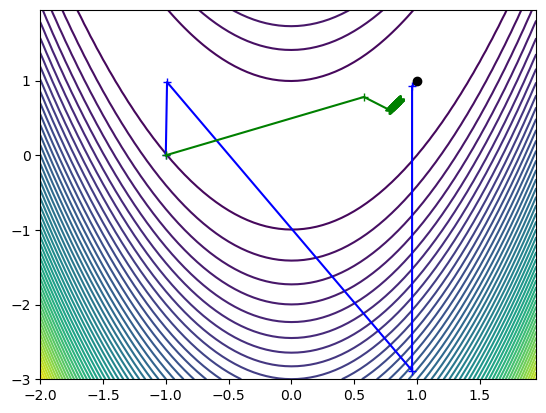

In [240]:
iteres_W, k_W,s =  ppd_RL_Wolfe(f1, g1, [-1,0], 300, 10**-5)
a,b=Newton_local(f1,g1,h1,[-1,0],300,10**-5)

plot_contour(-2, 2, -3, 2, f1)

plot_iteres(a, 'b')
plot_iteres(iteres_W, 'g')
plt.plot(1,1,'o',color = 'black')

### Illustration sur une autre fonction

Tester la méthode de Newton locale avec la fonction $f_2$ en partant du point $[1,1]$.

In [137]:
a,b=Newton_local(f2,g2,h2,[1,1],300,10**-5)
print('nombre d itération :' , b)
print('solution approché :' , a[-1])

nombre d itération : 3
solution approché : [-2.13237666e-06  1.57079327e+00]


Faire le tracé des itérés et des courbes de niveau de la fonction $f_2$ et commenter le résultat.

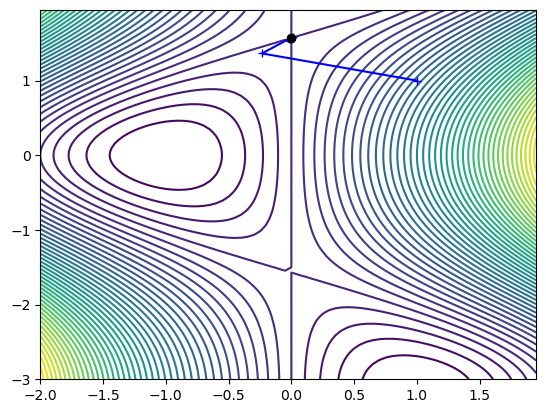

In [178]:
a,b=Newton_local(f2,g2,h2,[1,1],300,10**-5)

plot_contour(-2, 2, -3, 2, f2)

plot_iteres(a, 'b')
plt.plot(0,np.pi/2,'o',color = 'black')

On voit que newton local converge vers les points critique mais pas vers le minimum comme sur le schéma ci dessus (les min étant les trous).

## Newton globalisé

Commencer par construire une fonction qui, pour une matrice $A$ donnée, produit une matrice $L$ et un réel positif $\mu$ tels que
$$
A + \mu I = L L^\top.
$$
Pour ce faire on utilisera le pseudo-algorithme suivant : 
* k = 0
* si $\min_i a_{ii} > 0$, alors $\mu_k = 0$, sinon $\mu_k = \frac{1}{2}\|A\|_F$.
* Itérations : 
    - calculer la factorisation de Cholesky $LL^\top de$ $A + \mu_k I$
    - si succès, alors STOP
    - sinon, $\mu_{k+1} = \max\left(2\mu_k, \frac{1}{2}\|A\|_F \right)$.
    - k = k+1
* retourner $L$ et $\mu_k$.

In [190]:
def choleski_mod(A):
    mu=0
    I=np.identity(np.shape(A)[0]) #on def la matrice identité
    k=0
    if np.min(np.diag(A))>0:  # condition sur les min de la diag
        mu=0
    else:
        mu=(1/2)*np.linalg.norm(A,'fro')                
    while True:             #tant que c vrai (donc boucle à l'infinie)
        try:                # On essaie la décomposition de cholesky
            L=np.linalg.cholesky(A+mu*I)
            break           # si sa marche on sort de la boucle
        except np.linalg.LinAlgError :   #si sa fait erreur on change le mu et on refait une boucle
            mu=max(2*mu,(1/2)*np.linalg.norm(A,'fro'))
        k=k+1
    return(L,mu)

                    
print(choleski_mod(np.array([[1,0],[0,-4]])))                    
                        
        

(array([[2.26342785, 0.        ],
       [0.        , 0.35086411]]), 4.123105625617661)


Construire une fonction qui met en oeuvre la méthode de Newton globalisée. Plus précisément, on passera d'un itéré $x_k$ au suivant $x_{k+1}$ par la formule
$$
x_{k+1} = x_k+ s_k d_k
$$
où 
* $s_k$ est le résultat de la recherche linéaire de Wolfe qui démarre à $s_0 = 1$
* et $d_k$ est la solution de $H_k d_k = -\nabla f(x_k)$ avec $H_k = \nabla^2 f(x_k) +\mu I$ pour $\mu$ assez grand pour que $H_k$ soit définie-positive.

A vrai dire, $d_k$ est le résultat du processus suivant : 
* on cherche $L$ et $\mu_k$ tels que $\nabla^2 f(x_k) +\mu_k I = LL^\top$ ; 
* on résout $Lv = -\nabla f(x_k)$
* et enfin on résout $L^\top d_k = v$.

In [203]:
def Newton_global(f,g,h,X0,IterMax,eps):
     # f est la fonction qui évalue le critère pour en un point X donné
    # g est la fonction qui évalue le gradient du critère pour en un point X donné
    # X0 est le point de départ de l'algorithme
    # IterMax est le nombre d'itérations réalisées
    # eps est une tolérance fixée pour le critère d'arrêt
        
    X      = X0.copy()
    iteres = np.zeros(shape=(IterMax+1, len(X))) # pour stocker les itérés
    steps  = np.zeros(shape=(IterMax,)) # pour stocker les pas successifs
    iteres[0]=X
    k = 0

    while arrêt(X,g,eps,k,IterMax)== False:
        # Calcul de la direction de descente
        L=choleski_mod(h(X))[0]
        v=np.linalg.solve(L,-g(X))
        d_k = np.linalg.solve(np.transpose(L),v)
        
         #pas de wolf
        s_k = RL_WOLFE(X, d_k, f, g, s0 = 1.0, eps1 = 0.01, eps2 = 0.99)
        
        # Stockage du pas
        steps[k] = s_k 
        
        # Calcul de l'itéré suivant
        X=X + s_k*d_k

        # Stockage du nouvel itéré
        iteres[k+1] = X
        
        k = k+1
        # Mise à jour du critère d'arrêt
        
        

    return iteres[:k+1,:], k, steps[:k]

### Illustration sur la fonction de Rosenbrock

Représenter sur un même graphique 
* les courbes de niveau de la fonction de Rosenbrock, 
* le point de minimum global de la fonction de Rosenbrock par un **cercle noir**,
* les itérés de la methode de Newton locale **en bleu**, 
* les itérés de la méthode de Newton globalisée **en rouge**.

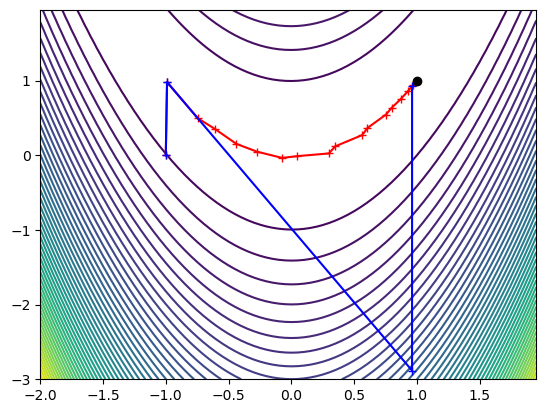

In [204]:
a1,b1,c1=Newton_global(f1,g1,h1,[-1,0],300,10**-5)
a2,b2=Newton_local(f1,g1,h1,[-1,0],300,10**-5)


plot_contour(-2, 2, -3, 2, f1)

plot_iteres(a1, 'r')
plot_iteres(a2, 'b')
plt.plot(1,1,'o',color = 'black')

### Illustration sur la fonction $f_2$

Représenter sur un même graphique 
* les courbes de niveau de la fonction $f_2$,
* les itérés de la methode de Newton locale **en bleu**, 
* les itérés de la méthode de Newton globalisée **en rouge**.

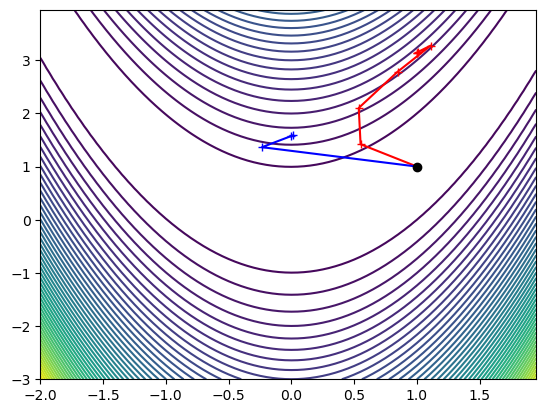

In [205]:
a1,b1,c1=Newton_global(f2,g2,h2,[1,1],300,10**-5)
a2,b2=Newton_local(f2,g2,h2,[1,1],300,10**-5)


plot_contour(-2, 2, -3, 4, f1)

plot_iteres(a1, 'r')
plot_iteres(a2, 'b')
plt.plot(1,1,'o',color = 'black')

## Une méthode de quasi-Newton : BFGS

On s'intéresse maintenant à la mise en oeuvre d'une méthode de quasi-Newton qui permet d'éviter le calcul de la hessienne de la fonction à minimiser.

Partant d'un itéré initial et d'une matrice $B_0$ initiale (on prendra ici l'identité) supposée approcher l'inverse de la hesiienne de $f$, on passera d'un itéré $x_k$ au suivant via les étapes :
* calcul de la direction $d_k = -B_k \nabla f(x_k)$ ; 
* calcul d'un pas $s_k > 0$ via la recherche linéaire de Wolfe en partant de $s_0 = 1$ ; 
* $x_{k+1} = x_k + s_k d_k$ ; 
* mise à jour de la matrice de quasi-Newton : 
$$
B_{k+1} = \left(I- \frac{y_k\sigma_k^\top}{y_k^\top\sigma_k}\right)^\top B_k \left(I- \frac{y_k\sigma_k^\top}{y_k^\top\sigma_k}\right) +\frac{\sigma_k\sigma_k^\top}{y_k^\top\sigma_k},
$$
avec $\sigma_k = x_{k+1}-x_k$ et $y_k = \nabla f(x_{k+1} -\nabla f(x_k)$.

Ecrire une fonction qui, connaissant $B$, $\sigma$ et $y$, met en oeuvre la formule de mise à jour de la matrice de quasi-Newton écrite ci-dessus.

In [231]:
def maj_BFGS(B,sigma,y):
    (a,b)=np.shape(B)
    c=np.dot(y,sigma)
    sigma_trs=np.transpose(np.array([sigma]))
    y_trs=np.transpose(np.array([y]))
    d=np.identity(a)-np.dot(y_trs,np.transpose(sigma_trs))/c
    X=np.dot(np.transpose(d),np.dot(B,d))+np.dot(sigma_trs,np.transpose(sigma_trs))/c #formule de Bk+1
    return(X)
    
    
    

Ecrire une fonction qui met en oeuvre l'algorithme de BFGS décrit ci-dessus pour minimiser une fonction $f$.

In [232]:
def BFGS(f,g,X0,B0, IterMax,eps):
     # f est la fonction qui évalue le critère pour en un point X donné
    # g est la fonction qui évalue le gradient du critère pour en un point X donné
    # X0 est le point de départ de l'algorithme
    # IterMax est le nombre d'itérations réalisées
    # eps est une tolérance fixée pour le critère d'arrêt
        
    X      = X0.copy()
    iteres = np.zeros(shape=(IterMax+1, len(X))) # pour stocker les itérés
    steps  = np.zeros(shape=(IterMax,)) # pour stocker les pas successifs
    iteres[0]=X
    k = 0
    B=B0

    while arrêt(X,g,eps,k,IterMax)== False:
        # Calcul de la direction de descente
        d_k = -np.dot(B,g(X))
        
        #pas de wolf
        s_k = RL_WOLFE(X, d_k, f, g, s0 = 1.0, eps1 = 0.01, eps2 = 0.99)
        
        # Stockage du pas
        steps[k] = s_k 
        
        # Calcul de l'itéré suivant
        X=X + s_k*d_k

        # Stockage du nouvel itéré
        iteres[k+1] = X
        
        #Calcul du nouveau B
        sigma = iteres[k+1]-iteres[k]
        y=g(iteres[k+1])-g(iteres[k])
        B=maj_BFGS(B,sigma,y)
        
        k = k+1
        # Mise à jour du critère d'arrêt
        
        

    return iteres[:k+1,:], k, steps[:k]
    

### Illustration sur la fonction de Rosenbrock

Représenter sur un même graphique 
* les courbes de niveau de la fonction de Rosenbrock, 
* le point de minimum global de la fonction de Rosenbrock par un **cercle noir**,
* les itérés de la methode de Newton locale **en bleu**, 
* les itérés de la méthode de Newton globalisée **en rouge**,
* les itérés de la méthode de quasi-Newton **en orange**.

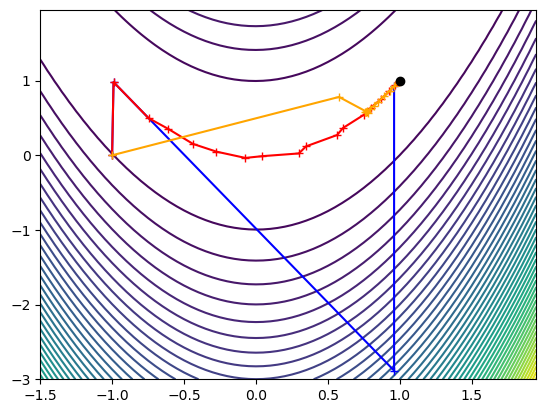

In [234]:
X0 = np.array([-1,0])
IterMax = 300
eps = 10**-5

plot_contour(-1.5, 2, -3, 2, f1)

a1, b1 = Newton_local(f1, g1, h1, X0, IterMax, eps)

a2, b2, c2 =  Newton_global(f1, g1,h1, X0, IterMax, eps)

a3,b3,c3 = BFGS(f1, g1, X0,np.identity(np.shape(h1(X0))[0]), IterMax, eps)



plot_iteres(a1, 'b')
plot_iteres(a2, 'r')
plot_iteres(a3,'orange')
plt.plot(1,1,'o',color = 'black')

### Illustration sur la fonction $f_2$

Représenter sur un même graphique 
* les courbes de niveau de la fonction $f_2$,
* les itérés de la methode de Newton locale **en bleu**, 
* les itérés de la méthode de Newton globalisée **en rouge**,
* les itérés de la méthode de quasi-Newton **en orange**.

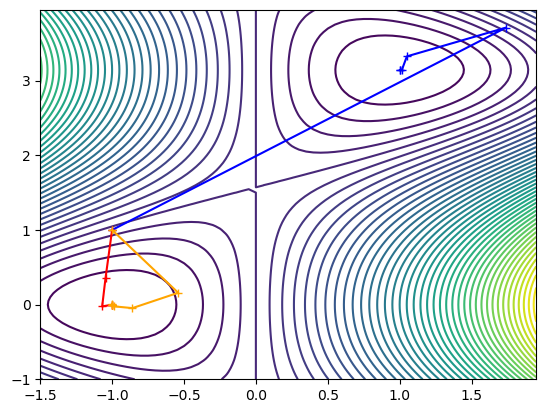

In [242]:
X0 = np.array([-1,1])
IterMax = 300
eps = 10**-5

plot_contour(-1.5, 2, -1, 4, f2)

a1, b1 = Newton_local(f2, g2, h2, X0, IterMax, eps)

a2, b2, c2 =  Newton_global(f2, g2,h2, X0, IterMax, eps)

a3,b3,c3 = BFGS(f2, g2, X0,np.identity(np.shape(h2(X0))[0]), IterMax, eps)



plot_iteres(a1, 'b')
plot_iteres(a2, 'r')
plot_iteres(a3,'orange')


# Problème des moindres carrés

Les problèmes de moindres carrés sont des problèmes d'optimisation s'écrivant sous la forme
$$\min_{x\in\mathbb{R}^n} \frac{1}{2} \|r(x)\|^2,$$
où $r : \mathbb{R}^n \to \mathbb{R}^N$ est différentiable.

Ces problèmes apparaissent notamment lorsqu'on souhaite calibrer les paramètres d'un modèle mathématique en utilisant des données. Voyons comment ci-dessous.

On considère un système dont chaque configuration $i$ définie par des valeurs d'entrée $\alpha_i$ produit des valeurs de sortie $\beta_i$. On dispose d'un modèle mathématique permettant de prédire les valeurs de sortie en fonction des valeurs d'entrée : 
$$
\beta_i + \epsilon_i = m(\alpha_i ; x),
$$
où $x$ représente les paramètres du modèle et $\epsilon_i$ est une variable aléatoire de moyenne nulle et de variance $\sigma^2$ représentant les erreurs de modélisation et de mesure.

On cherche à ajuster les paramètres $x$ du modèle $m$ en minimisant l'erreur : 
$$
\min_{x, \epsilon} \sum_i \epsilon_i^2,
$$
sous la contrainte 
$$
\beta_i + \epsilon_i = m(\alpha_i ; x).
$$
Ce problème se reformule (en utilisant la contrainte pour éliminer $\epsilon$) :
$$
\min_x \sum_i \left(m(\alpha_i ; x) - \beta_i\right)^2.
$$
Il s'agit bien d'un problème de moindres carrés avec $r_i(x) = m(\alpha_i ; x) - \beta_i$.

## Exemple linéaire : résistivité $\rho$ du cuivre

Afin de mesurer la résistivité du cuivre, on utilise une barre de 1 mètre de long et 1 ${\rm cm}^2$ de section. On effectue plusieurs expériences, consistant à envoyer des courants de diverses intensités et à mesurer les différences de potentiel résultantes. Les résultats des 21 expériences sont dans les tableaux *I* et *U*.

Représenter ces points par des étoiles sur un graphe d'abscisse l'intensité et d'ordonnée la différence de potentiel.

Text(0, 0.5, 'différence de potentiel')

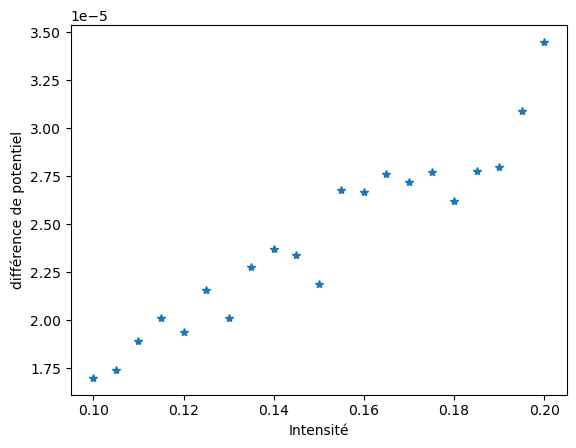

In [9]:
I = 1.0e-3*np.linspace(100, 200, 21)
U = 1.0e-5*np.array([1.7, 1.74, 1.89, 2.01, 1.94, 2.16, 2.01, 2.28, 2.37, 2.34, 
                       2.19, 2.68, 2.67, 2.76, 2.72, 2.77, 2.62, 2.78, 2.80, 3.09, 3.45])

plt.plot(I,U,'*')
plt.xlabel('Intensité')
plt.ylabel('différence de potentiel')


Nous cherchons à évaluer la *résistance* $R$ de cette barre en utilisant la loi d'Ohm $U = RI$.
La fonction $r$ dans cet exemple sera nommée $Ohm : \mathbb{R} \to \mathbb{R}^{21}$. Elle est définie par 
$$
Ohm_i(R) = R \times I_i - U_i.
$$

Ecrire une fonction qui calcule $Ohm(R)$ et une autre qui calcule sa jacobienne.

In [16]:
def Ohm(R,I,U):
    A=[R*I[k]-U[k] for k in range(len(I))]
    return(np.array(A))

def Jacob_Ohm(R,I,U):
    A=np.array([I[k] for k in range(len(I))])
    B=np.transpose(A)
    return(B)
   

Cet exemple servira à tester les méthodes ci-dessous.

Indication : le lien entre la résistance de la barre et la résistivité du cuivre est le suivant : 
$$
\rho = \frac{S}{\lambda} R,
$$
où $S$ est la section de la barre et $\lambda$ sa longueur. Ainsi $\frac{S}{\lambda} = 10^{-4}$.

## Exemple non linéaire : réseau de neurones élémentaire

On cherche à approcher les données suivantes  

|a|b|
|-------|-------|
|  1.165 |  1 |
|  0.626 | -1 |
|  0.075 | -1 |
|  0.351 |  1 |
| -0.696 |  1 |

en utilisant pour fonction $r$ la fonction $N : \mathbb{R}^2 \to \mathbb{R}^5$ définie pour tout $x \in \mathbb{R}^2$ par
$$N_i(x) = \phi(x_1 a_i + x_2)-b_i,$$
avec $$\phi(z) = \frac{e^z-e^{-z}}{e^z+e^{-z}}$$ la tangente hyperbolique.

Ecrire une fonction qui calcule $N(x)$ et une autre qui calcule sa jacobienne.

In [24]:
def phi(z):
    return((np.exp(z)-np.exp(z))/(np.exp(z)+np.exp(-z)))


def N(x,a,b):
           A=np.array([phi(x[0]*a[k]+x[1])-b[k] for k in range(len(a))])
           return(A)
           
a=[1.165,0.626,0.075,0.351,-0.696]
b=[1,-1,-1,1,1]
           
def jacob_N(x,a,b):
    A=np.zeros((len(a),2))
    for k in range(len(a)):
        A[k,0]=a[k]*(4/(np.exp(x[0]*a[k]+x[1])+np.exp(-x[0]*a[k]+x[1]))**2)
        A[k,1]=(4/(np.exp(x[0]*a[k]+x[1])+np.exp(-x[0]*a[k]+x[1]))**2)
    return(A)
    
    
    

[[ 1.165  1.   ]
 [ 0.626  1.   ]
 [ 0.075  1.   ]
 [ 0.351  1.   ]
 [-0.696  1.   ]]


## Méthode de Gauss-Newton

Pour appliquer la méthode de Newton (locale ou globalisée), au problème des moindres carrés, il faut calculer le gradient et la matrice hessienne du problème 
$$\min_{x\in\mathbb{R}^n} \frac{1}{2} \|r(x)\|^2.$$

Comme $f(x) := \frac{1}{2} \|r(x)\|^2 = \frac{1}{2} \sum_i (r_i(x))^2$, on a 
$$
\nabla f(x) = \sum_i r_i(x) \nabla r_i(x) = Jr(x)^\top r(x)
$$
et 
$$
\nabla^2 f(x) = \sum_i \Bigg( \nabla r_i(x) \left(\nabla r_i(x) \right)^\top + r_i(x) \nabla^2 r_i(x) \Bigg)
= Jr(x)^\top Jr(x) + \sum_i r_i(x) \nabla^2 r_i(x).
$$

Le deuxième terme intervenant dans le calcul de la matrice hessienne est généralement très couteux à calculer en pratique. 

La **méthode de Gauss-Newton** consiste à ignorer ce dernier terme et à approcher la matrice hessienne de $f$ par le terme $Jr(x)^\top Jr(x)$, qui est toujours semi définie positive !

Mettre en oeuvre cette méthode : 
* Entrées : 
    - la fonction $r$,
    - la fonction qui calcule la jacobienne $Jr$ de $r$,
    - un point de départ $x_0$
    - et une tolérance $\varepsilon > 0$.
* Sortie : une approximation de la solution du problème de moindres carrées.
* On passe d'un itéré au suivant au moyen de étapes suivantes :
    - calcul de la direction $d_k$ solution de  $$Jr(x_k)^\top Jr(x_k) d_k = -Jr(x_k)^\top r(x_k),$$
    - calcul d'un pas $s_k$ par une recherche linéaire de Wolfe.
    - calcul du nouvel itéré $$x_{k+1} = x_k + s_kd_k.$$

In [33]:
a=[1.165,0.626,0.075,0.351,-0.696]
b=[1,-1,-1,1,1]

def arrêt(X,Jr,eps,k,IterMax):
    return(np.linalg.norm(Jr(X,a,b))< eps or k >= IterMax)
   


def Gauss_newton(r,Jr,X0,eps,IterMax):

    X      = X0.copy()
    iteres = np.zeros(shape=(IterMax+1, len(X))) # pour stocker les itérés
    steps  = np.zeros(shape=(IterMax,)) # pour stocker les pas successifs
    iteres[0]=X
    k = 0

    while arrêt(X,Jr,eps,k,IterMax)== False:
        # Calcul de la direction de descente
        d_k = np.linalg.solve(np.transpose(Jr[X,a,b])*Jr[X,a,b],-np.transpose(Jr[X,a,b])*r(X))
        
        #pas de wolf
        s_k = RL_WOLFE(X, d_k, r, Jr, s0 = 1.0, eps1 = 0.01, eps2 = 0.99)
        
        # Stockage du pas
        steps[k] = s_k 
        
        # Calcul de l'itéré suivant
        X=X + s_k*d_k

        # Stockage du nouvel itéré
        iteres[k+1] = X
        

        k = k+1
        # Mise à jour du critère d'arrêt
        
        

    return iteres[:k+1,:], k, steps[:k]

print(Gauss_newton(N,jacob_N,[0,0],10**-5,500))

TypeError: 'function' object is not subscriptable

Tester cette méthode de Gauss-Newton sur les deux exemples précédents : loi d'Ohm et réseau de neurones.

## Méthode de Levenberg-Marquardt

Le code précédent fonctionne si la matrice $Jr(x_k)^\top Jr(x_k)$ est régulière parce qu'elle est alors définie-positive et la méthode de Gauss-Newton est bien une méthode de descente.

Si la matrice $Jr(x_k)^\top Jr(x_k)$ est singulière, on peut utiliser la technique basée sur la factorisation de Cholesky pour corriger la matrice. 

Cette amélioration mène à la méthode de Levenberg-Marquardt, qu'on implémentera ici.

Tester la méthode de Levenberg-Marquardt sur la loi d'Ohm et le réseau de neurones.